In [217]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Nick\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['gray']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Get images from visual sensor

In [218]:
import sim as vrep
import time
import cv2
import numpy as np

In [220]:
vrep.simxFinish(-1)

clientID = vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

img_array = []
pitch_array = []
yaw_array = []

if clientID!=-1:
    # Handler for the camera
    res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
    print ('Getting first image')
    err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
    
    # Take p pictures
    p = 14
    i = 0
    while i < p:     
        err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_buffer)
        if err == vrep.simx_return_ok:
            # Store image
            print ("image %d OK!!!"%i)
            img = np.array(image,dtype=np.uint8)
            img.resize([resolution[1],resolution[0],3])
            # Show the images using Opencv (uncomment if you want to try it)
#            cv2.imshow('image',img)
#            if cv2.waitKey(1) & 0xFF == ord('q'): break
            img_array.append(img)
            # Store object orientation
            # angles are (pitch,roll,yaw) format
            oerr, angles = vrep.simxGetObjectOrientation(clientID, v1, 0, vrep.simx_opmode_streaming)
            pitch_array.append(angles[0])
            yaw_array.append(angles[2])
            i+=1
        elif err == vrep.simx_return_novalue_flag:
            print ("no image yet")
            pass
        else:
          print (err)
        time.sleep(4)
else:
  print ("Failed to connect to remote API Server")
  vrep.simxFinish(clientID)

Getting first image
no image yet
image 0 OK!!!
image 1 OK!!!
image 2 OK!!!
image 3 OK!!!
image 4 OK!!!
image 5 OK!!!
image 6 OK!!!
image 7 OK!!!
image 8 OK!!!
image 9 OK!!!
image 10 OK!!!
image 11 OK!!!
image 12 OK!!!
image 13 OK!!!


In [221]:
img_array_grayscale = []
# Convert to gray scale
for img in img_array:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_array_grayscale.append(gray)
    #imshow(gray, cmap='gray')

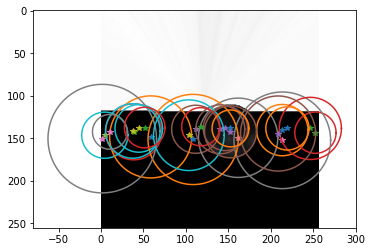

In [222]:
# Array of circles of format (x-coord of center, y-coord of center, radius)
circles_array = []
# Each entry in this array is the orientation of the circle with 
# corresponding index in the circles array.
circle_angles = []

###

ind = 0
for gray in img_array_grayscale:
    gray = cv2.medianBlur(gray,5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, gray.shape[0] / 8, param1=30,param2=15,minRadius=10,maxRadius=0)
    imshow(gray, cmap='gray')
    #print(circles)
    if circles is not None:
        for circle in circles[0, :]:
            # Append to circles array for use outside of scope
            circles_array.append(circle)
            # Append orientation of robot corresponding to the circle
            circle_angles.append(pitch_array[ind])
            # Get circle data - center and redius
            center = (circle[0], circle[1])  # In pixels
            radius = circle[2]  # In pixels
        
            # plot circle
            s = linspace(0,2*pi,100)
            cx = cos(s)*radius + center [0]
            cy = sin(s)*radius + center [1]
            # Plot center
            plot(center[0], center[1], '*')
            plot(cx,cy)

    ind=ind+1


In [223]:
xc_array = []
zc_array = []
k_array = []

for i in range(len(circles_array)):
    u0, v0 = 132, 132
    radius = circles_array[i][2]
    
    k = radius / (1.5 / 2)  # Pixels per meters (radius in pixels / radius in  meters)
    k_array.append(k)
    fov = 60  # degrees

    # number of pixels in x-axis
    npx = 264

    # maximum value in the x-axis (in meters)
    xmax = npx / (2.* k)

    # Distance to the center of the sphere (z-axis coordinate)
    zc = xmax / tan(pi/6)
    zc

    # Location of the sphere in the x-axis coordinate
    xc = (circles_array[i][0] - u0) / k
    xc
    
    zc_angle = zc*cos(circle_angles[i]) + xc*sin(circle_angles[i])
    xc_angle = xc*cos(circle_angles[i]) - zc*sin(circle_angles[i])
    
    xc_array.append(xc_angle)
    zc_array.append(zc_angle)
    xc, zc

In [224]:
k_array, xc_array, zc_array, len(k_array) == len(xc_array) == len(zc_array) == len(circles_array) == len(circle_angles) #==22

([40.26666768391927,
  44.0,
  37.73333231608073,
  62.26666768391927,
  36.26666768391927,
  64.39999898274739,
  32.3999989827474,
  34.800000508626304,
  75.86666870117188,
  37.333333333333336,
  70.7999979654948,
  48.79999796549479,
  38.3999989827474,
  85.2000020345052,
  42.79999796549479,
  33.86666615804037,
  30.0,
  58.93333435058594,
  27.333333333333332,
  55.46666463216146,
  28.933334350585938,
  31.866666158040363,
  40.800000508626304],
 [2.024006571384289,
  -2.125,
  4.653432108313942,
  3.30355915054162,
  3.239466425614805,
  -2.207231046387713,
  -7.897113676281855,
  -5.586956722827673,
  -3.077228379772738,
  -3.6246482696329103,
  -2.4350003073548208,
  -5.176220248375579,
  -4.976649343180799,
  -1.2959811226892262,
  -3.0481858918637017,
  -6.989445137398572,
  -5.879175451364504,
  3.9311020946697237,
  4.36588702896346,
  3.0729780292413795,
  6.866808301313859,
  4.4161504605510125,
  4.868100039824272],
 [5.677914755543499,
  5.196152422706632,
  3.9183

### Grid representation

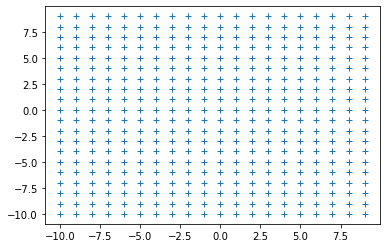

In [225]:
# The map is 20x20 sq meters
#Lets define a grid of nxn
n = 20
gmap = zeros(n*n) # the map is a grid of nxn

# x and y coordinates for the grid cells. Lowest and leftest point in the cell.
cell_w = 20/n
grid_x, grid_y = np.mgrid[-10:10:cell_w,-10:10:cell_w]
# Convert the matrix into a vector
grid_x = grid_x.flatten()
grid_y = grid_y.flatten()

plot(grid_x, grid_y, '+')

Draw each cell independently

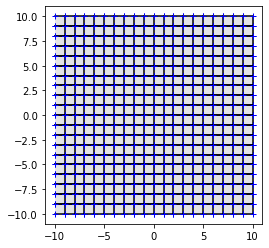

In [226]:
# Computes the four points of the square that composes a cell
def points_cell(x, y, d):    
    X = [x, x+d, x+d, x]
    Y = [y, y, y+d, y+d]
    return X, Y

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# plot each cell
for x, y in zip(grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='0.9')
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    
fig.canvas.draw()

## Use the measurement

In [227]:
l0 = (0.3/(1-0.3))  # Initial belief
gmap = l0 * ones(n*n) # Initial belief

# For each circle
for c_ind in range(len(xc_array)):
    # For each cell, check if the circle is in it.
    for i in range(n*n):
        x, y = grid_x[i], grid_y[i]
        # Corners of the cell
        X, Y = points_cell(x, y, cell_w)
        # check based on the ecuclidean distance
        xc = xc_array[c_ind]
        zc = zc_array[c_ind]
        dist = sqrt((xc - X)**2 + (zc - Y)**2)

        # Check if At least one of the borders is within the sphere
        if((dist < radius/k_array[c_ind]).any()):
            print(dist)
            po = 0.8  # P(mi/zt) probability of having an obstacle 
            li = log(po / (1-po)) + gmap[i] - l0
            gmap[i] = li  # P(mi/zt) 
            print(li)
        else:
            po = 0.05  # P(mi/zt) probability of having an obstacle given a non-detected obstacle

            # Cells within the fov. Check if the four points are withing the FOV
            thetas = np.arctan2(Y,X) - pi/2
            if np.logical_and(-pi/6 <thetas, thetas < pi/6).all():
                li = log(po / (1-po)) + gmap[i] - l0
                gmap[i] = li

            pass

    # gmap

[1.96570277 1.67808648 0.67833969 1.22807079]
1.3862943611198908
[1.22807079 0.67833969 0.32297867 1.07346559]
1.3862943611198908
[1.07346559 0.32297867 1.32230318 1.67227356]
1.3862943611198908
[1.67808648 1.94112367 1.18833143 0.67833969]
1.3862943611198908
[0.67833969 1.18833143 1.02776558 0.32297867]
1.3862943611198908
[0.32297867 1.02776558 1.64331146 1.32230318]
1.3862943611198908
[1.48202754 1.20266605 0.23259573 0.89671666]
1.3862943611198908
[0.89671666 0.23259573 0.81350841 1.18819019]
1.3862943611198908
[1.20266605 1.64207357 1.14197232 0.23259573]
-1.986716046617978
[0.23259573 1.14197232 1.38267709 0.81350841]
-1.986716046617978
[1.89136054 1.12711157 0.65851095 1.65544583]
1.3862943611198908
[1.65544583 0.65851095 1.26368226 1.97579277]
1.3862943611198908
[1.12711157 0.98158864 0.35605119 0.65851095]
1.3862943611198908
[0.65851095 0.35605119 1.13579427 1.26368226]
1.3862943611198908
[0.98158864 1.62992394 1.34903974 0.35605119]
1.3862943611198908
[0.35605119 1.34903974 1.

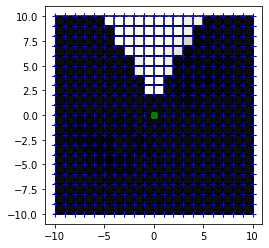

In [228]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

# normalize gmap
gmap = gmap - min(gmap)
gmap = gmap / max(gmap)

# plot each cell
for c, x, y in zip(gmap, grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='%f'%(1-c))
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    plot(0,0, 'go')
    
fig.canvas.draw()